<h1 style="color:orange;text-align:center;font-family:courier;font-size:220%">Example - Medical Image Segmentation Model</h1>
<h3 style="color:orange;text-align:center;font-family:courier;font-size:110%"><u>Problem Statement</u></h3>
<p style="text-align:center"><img src="assets/image1.jpg" alt="ps" height="200" width="240"/>
<h3 style="color:red;text-align:center;font-family:courier;font-size:90%">In this figure, the tumor (pink thick line) is close to the stomach (red thick line). High doses of radiation are directed to the tumor while avoiding the stomach. The dose levels are represented by the rainbow of outlines, with higher doses represented by red and lower doses represented by green. Cancer takes enough of a toll. If successful, you'll enable radiation oncologists to safely deliver higher doses of radiation to tumors while avoiding the stomach and intestines. This will make cancer patients' daily treatments faster and allow them to get more effective treatment with less side effects and better long-term cancer control.</h3>

<p style="text-align:right">Acknowledgement : <a href=https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation>Kaggle UW Madison Challenge</a></p>


#### Import Dependencies and Dataset

In [1]:
import os
import cv2
import pandas as pd
from glob import glob
from utils import *

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.callbacks import *

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

train_images = sorted(glob('dataset_full/images/*.png'))[:-1200]
train_masks = sorted(glob('dataset_full/masks/*.png'))[:-1200]

val_images = sorted(glob('dataset_full/images/*.png'))[-1200:]
val_masks = sorted(glob('dataset_full/masks/*.png'))[-1200:]

batch_size=6
preprocessor = efficientnet.preprocess_input

#### Preprocess and visualization

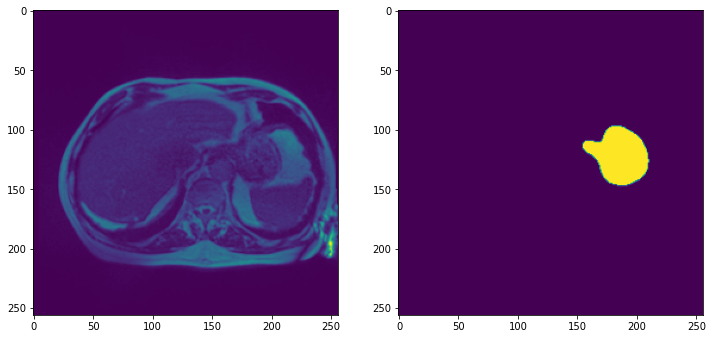

In [2]:
def preprocess_file(image,typ=None):
    image =tf.io.read_file(image)
    if typ=="source":
        image = tf.cast(tf.image.decode_png(image,channels=3),tf.float32)
        image = tf.image.resize(image,(256,256))
        return preprocessor(image)
    if typ=="target":
        image = tf.cast(tf.image.decode_png(image,channels=1),tf.float32)
        image = tf.image.resize(image,(256,256))
        return image
    
train_data = tf.data.Dataset.from_tensor_slices((train_images,train_masks))

train_data = train_data.map(lambda x,y :(preprocess_file(x,typ="source"),preprocess_file(y,typ="target")),
               num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size,drop_remainder=True).shuffle(30)



val_data = tf.data.Dataset.from_tensor_slices((val_images,val_masks))

val_data = val_data.map(lambda x,y :(preprocess_file(x,typ="source"),preprocess_file(y,typ="target")),
               num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size,drop_remainder=True).shuffle(30)

plt.figure(figsize=(12,6))
for x,y in train_data.take(1):
    plt.subplot(1,2,1)
    plt.imshow(x[0,:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(y[0,:,:,0])

#### Model Architecture

In [3]:
def transpose_decoder(current,nex,filters):
    scale = layers.Conv2DTranspose(filters,(2,2),strides=2)(current)
    scale = tf.keras.activations.gelu(scale)
    extract = layers.Conv2D(filters,3,padding="same")(nex)
    extract = tf.keras.activations.gelu(extract)
    
    concats = layers.concatenate((scale,extract))
    concats = layers.Conv2D(filters//2,1,padding="same")(concats)
    return concats

def segmentation_model():
    base_model = efficientnet.EfficientNetB4(include_top=False,input_shape=(256,256,3))
    
    e1 = base_model.get_layer("normalization").output #256,3
    e2 = base_model.get_layer("block2a_expand_activation").output #128,144
    e3 = base_model.get_layer("block3a_expand_activation").output #64,192
    e4 = base_model.get_layer("block4a_expand_activation").output #32,336
    e5 = base_model.get_layer("block6a_expand_activation").output #16,960
    
    d1 = transpose_decoder(e5,e4,512)
    d2 = transpose_decoder(d1,e3,256)
    d3 = transpose_decoder(d2,e2,128)
    d4 = transpose_decoder(d3,e1,64)
    
    output_layer = layers.Conv2D(4,(3,3),padding="same",activation="softmax")(d4)
    
    build = tf.keras.models.Model(base_model.input,output_layer)
    return build

#### Model Training

In [20]:
net = segmentation_model()

train_steps = len(train_images)//batch_size
val_steps = len(val_images)//batch_size

snapshots = 3
epochs    = 9
lr_       = 1e-4

def schedule(epoch):
    cos_inner = np.pi * (epoch % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    lr = float( lr_/ 2 * cos_out)
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    return lr


lrs = LearningRateScheduler(schedule)

logdir = "./logs/"
tensorboard = TensorBoard(logdir)
ckpt = ModelCheckpoint("segment.h5",save_best_only=True,save_weights_only=True,verbose=1)

net.compile(optimizer="Adam",
            loss="sparse_categorical_crossentropy",metrics=["acc"])

file_writer = tf.summary.create_file_writer(logdir)
file_writer.set_as_default()
net.load_weights("segment.h5")
net.fit(train_data,validation_data=val_data,batch_size=batch_size,epochs=epochs,
        steps_per_epoch=train_steps,validation_steps=val_steps,
        callbacks=[tensorboard,lrs,ckpt])

#### Model Testing

1/1 [==============================] - 0s 20ms/step


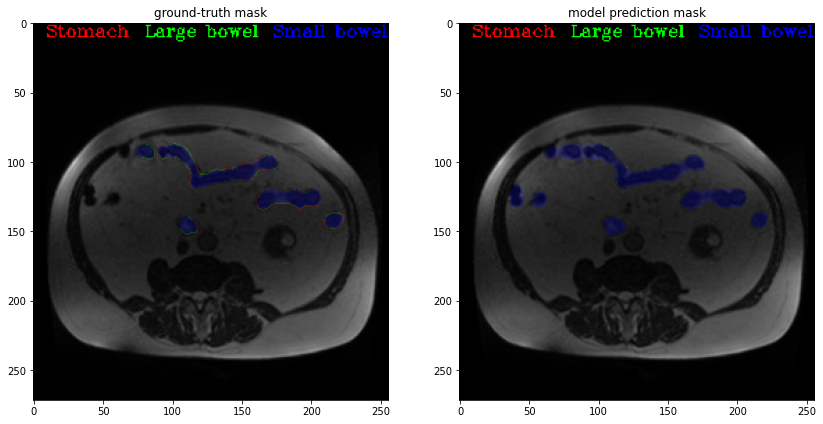

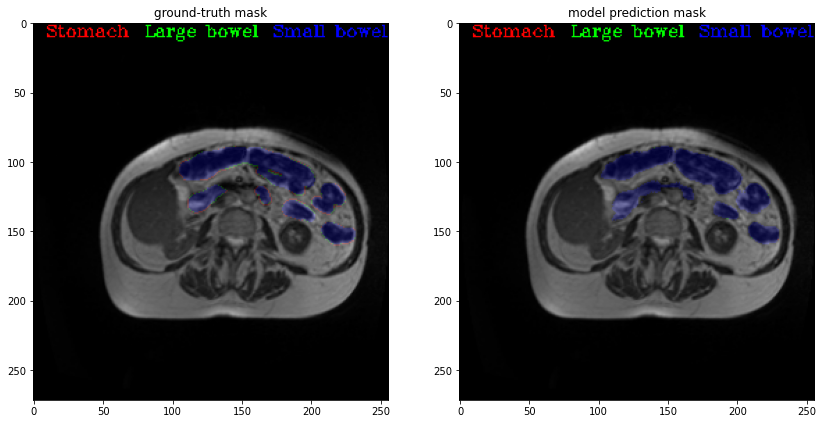

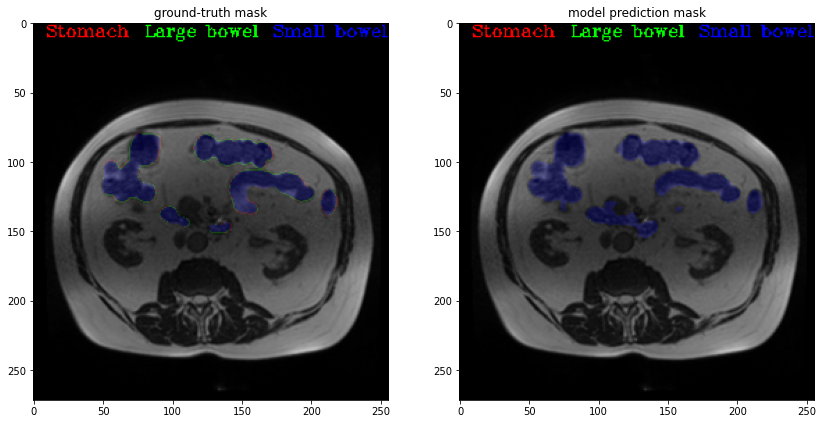

In [19]:
for i in range(3):
    image_str  = val_images[np.random.randint(0,190,1)[0]]

    size = 256
    mapping = {"stomach":[255,0,0],"large_bowel":[0,255,0],"small_bowel":[0,0,255]}

    prediction,image_disp = predict(image_str,preprocessor,net)
    mask = get_mask(prediction,mapping)
    pred_visualize = compose_visualize(image_disp,mask,mapping,size)

    mask_gt = cv2.resize(cv2.imread(image_str.replace("images","masks"),0),(size,size))
    mask_gt = get_mask(mask_gt,mapping)
    gt_visualize = compose_visualize(image_disp,mask_gt,mapping,size)


    plt.figure(figsize=(14,10))
    plt.subplot(1,2,1)
    plt.imshow(gt_visualize)
    plt.title("ground-truth mask")
    plt.subplot(1,2,2)
    plt.imshow(pred_visualize)
    plt.title("model prediction mask")